# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [115]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
import scipy.stats as stats
from scipy.stats import zscore
from time import time
from tqdm import tqdm
import joblib
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


sns.set_style("whitegrid")




In [116]:
def apr(y_pred, y_real):


    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


##

def produce_confusion(positive_label, negative_label,y_test,y_pred):
    
   
    #Build the CM
    plt.figure(figsize=(7,5))

    cm = metrics.confusion_matrix(y_test, y_pred) 
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label])

    plt.show()

In [117]:
booking_df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
booking_df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [118]:
# Select only the continuous features from the dataset
cont_features = booking_df.select_dtypes(include=['float', 'int']).columns.to_list()
cat_features = booking_df.select_dtypes(include=['object']).columns.to_list()


In [119]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

### Data Null Check

In [120]:
booking_df.isnull().mean().round(4) * 100

num_passengers           0.0
sales_channel            0.0
trip_type                0.0
purchase_lead            0.0
length_of_stay           0.0
flight_hour              0.0
flight_day               0.0
route                    0.0
booking_origin           0.0
wants_extra_baggage      0.0
wants_preferred_seat     0.0
wants_in_flight_meals    0.0
flight_duration          0.0
booking_complete         0.0
dtype: float64

In [121]:
booking_df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [122]:
booking_df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [123]:
booking_df.shape

(50000, 14)

Histogram of the continuous features 

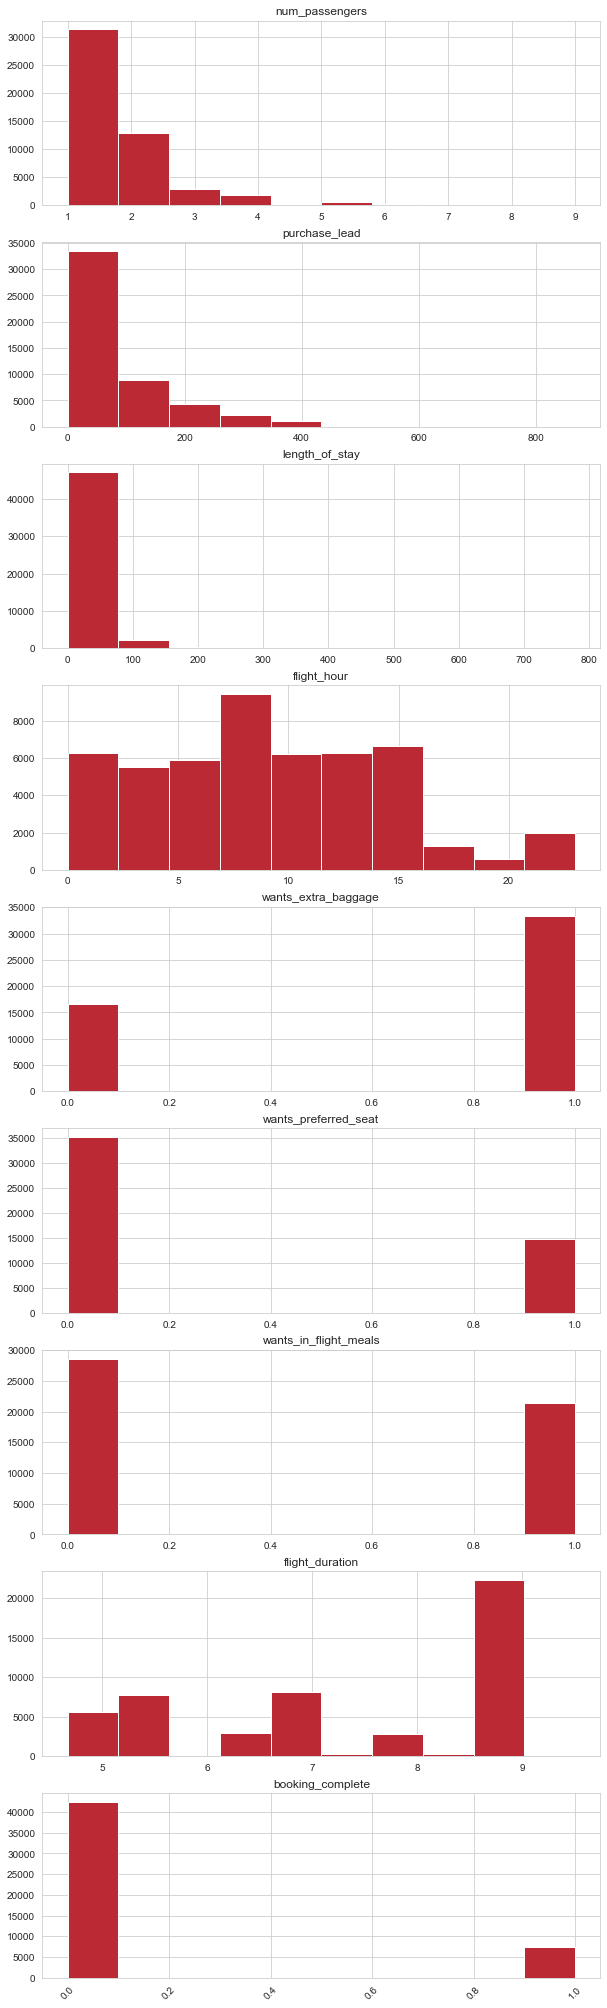

In [124]:
# Get the number of columns in the dataset

cont_df=booking_df[cont_features]

num_columns = cont_df.shape[1]

# Create a figure with a subplot for each column
fig, axes = plt.subplots(num_columns, figsize=(10, num_columns*4))
# Rotate the x-axis labels at an angle
plt.xticks(rotation=45)
# Plot a histogram for each column
for i in range(num_columns):
    column = cont_df.columns[i]
    axes[i].hist(cont_df[column])
    axes[i].set_title(column)
    #axes[i].set_xticks(rotation=45)

plt.show()

Normality Check

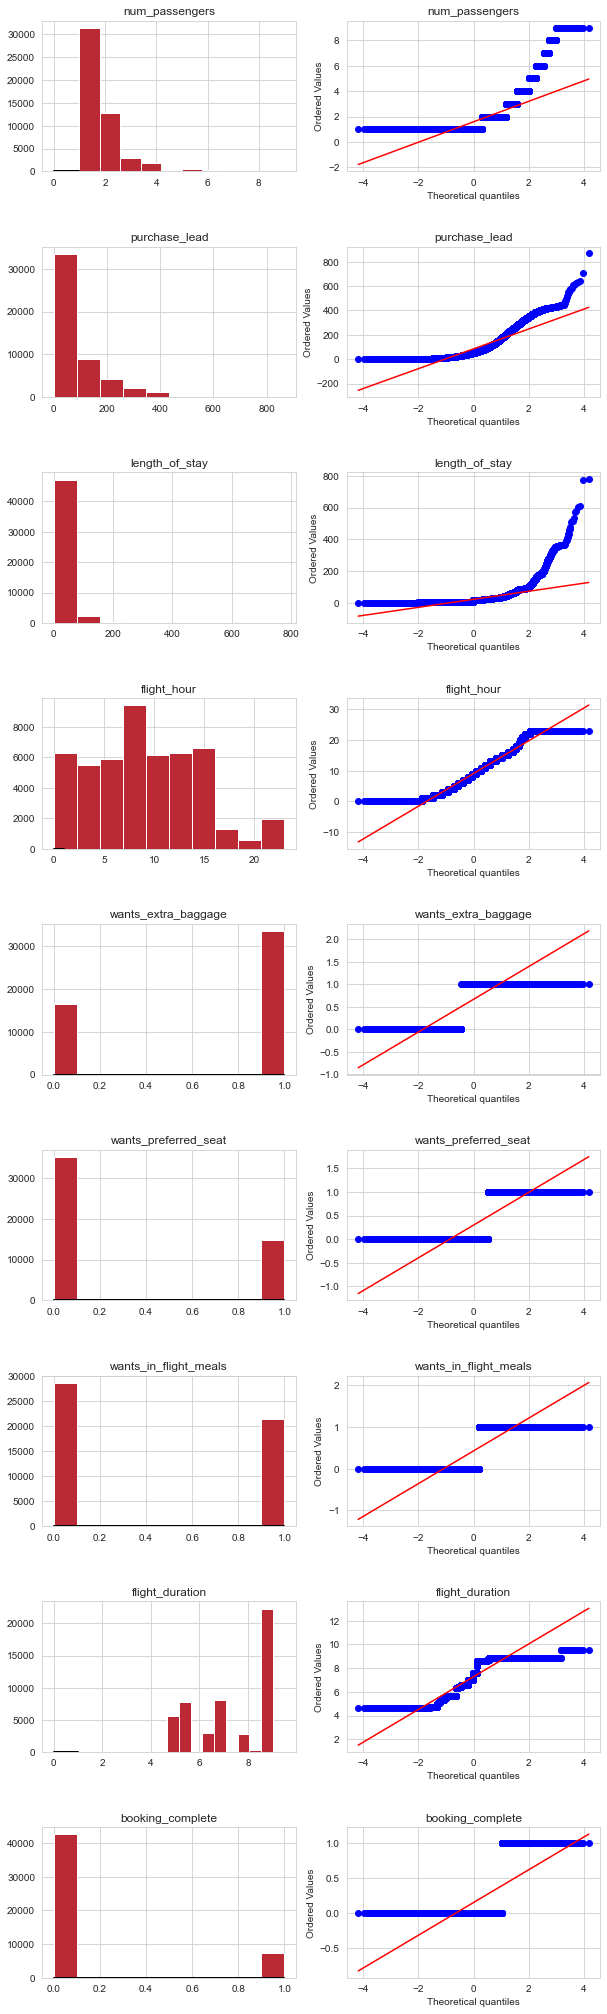

In [125]:




def check_normality(df):

    df=df[cont_features]
    num_columns=len(cont_features)
    # Create a figure with a subplot for each feature
    fig, axes = plt.subplots(num_columns, 2, figsize=(10, num_columns*4))
    fig.subplots_adjust(hspace=0.5)

    # Plot a histogram and normal quantile plot for each feature
    for i in range(num_columns):
        feature = df.columns[i]

        # Plot a histogram of the feature
        axes[i, 0].hist(df[feature])

        # Overlay a normal distribution on the histogram
        mu, std = stats.norm.fit(df[feature])
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        axes[i, 0].plot(x, p, 'k', linewidth=2)
        axes[i, 0].set_title(feature)

        # Create a normal quantile plot of the feature
        stats.probplot(df[feature], plot=axes[i, 1])
        axes[i, 1].set_title(feature)

    plt.show()

check_normality(booking_df)

If the sample is drawn from a normal distribution, the points in the plot will lie approximately on a straight line. Deviations from a straight line indicate departures from normality.

For example, if the points in the plot form a straight line, this suggests that the sample follows a normal distribution. On the other hand, if the points in the plot form a curved pattern, this suggests that the sample does not follow a normal distribution.

### Feature Engineering

In [126]:
booking_df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [127]:
a=[1,2,3]
b=[5,6]
a+b

[1, 2, 3, 5, 6]

In [128]:
def feature_engineer(df):


    cols_to_convert = [feature for feature in cont_features if len(booking_df[feature].unique())<4]
    # Convert the columns to string type
    df[cols_to_convert] = df[cols_to_convert].apply(lambda x: x.astype(str))

    # Label encode the columns
    df[cat_features] = df[cat_features].apply(LabelEncoder().fit_transform)

    # Convert the columns to string type
    df[cat_features+cols_to_convert] = df[cat_features+cols_to_convert].apply(lambda x: x.astype(str))

    return df

booking_df_new=feature_engineer(booking_df)
booking_df_new.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,0,2,262,19,7,2,0,61,1,0,0,5.52,0
1,1,0,2,112,20,3,2,0,61,0,0,0,5.52,0
2,2,0,2,243,22,17,6,0,36,1,1,0,5.52,0
3,1,0,2,96,31,4,2,0,61,0,0,1,5.52,0
4,2,0,2,68,22,15,6,0,36,1,0,1,5.52,0


In [129]:
# Select only the continuous features from the dataset
cont_features = booking_df.select_dtypes(include=['float', 'int']).columns.to_list()
cat_features = booking_df.select_dtypes(include=['object']).columns.to_list()
cont_features

['num_passengers',
 'purchase_lead',
 'length_of_stay',
 'flight_hour',
 'flight_duration']

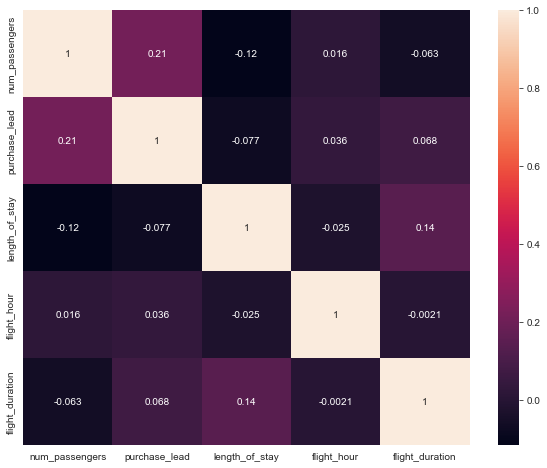

In [130]:
def plot_corr(df):
    plt.figure(figsize=(10, 8))

    # Set the color palette
    sns.set_palette(sns.color_palette("RdBu", n_colors=7))

    sns.heatmap(df.corr(),annot=True)
    plt.show()

plot_corr(booking_df_new)

### Check for Outliers

We can use statistical methods, such as the <b>Z-score</b> or the <b>interquartile range (IQR)</b>, to identify and quantify outliers in the dataset. For example, you can calculate the Z-scores of the values in the feature and consider values with a Z-score greater than 3 or less than -3 to be outliers. You can also use the IQR to identify outliers as values that fall outside of the range of Q1 - 1.5IQR to Q3 + 1.5IQR, where Q1 and Q3 are the first and third quartiles of the feature, respectively, and IQR is the interquartile range.

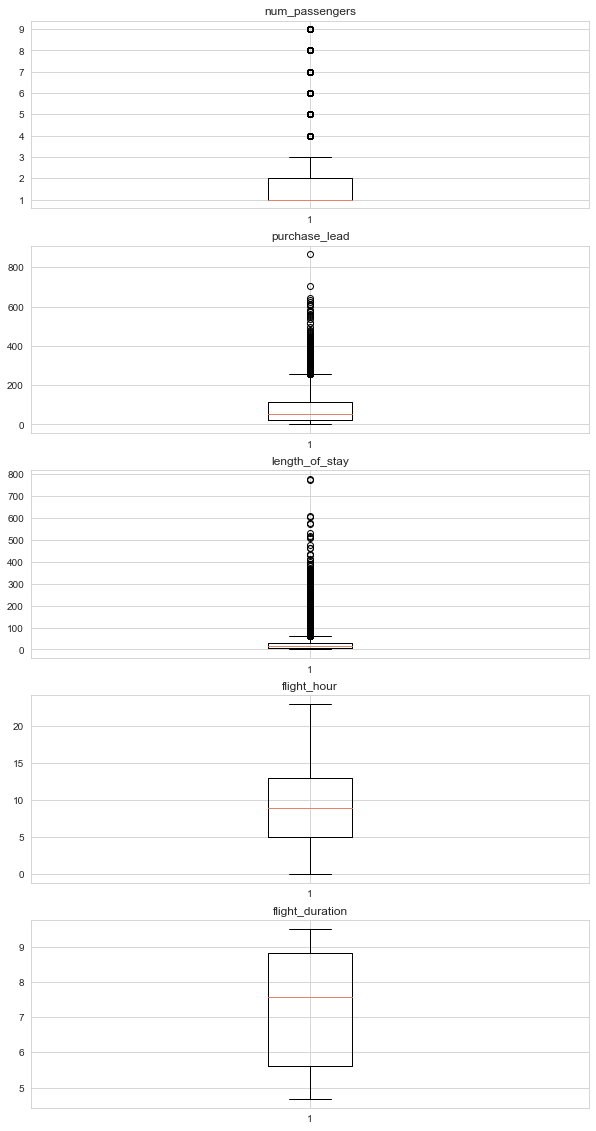

In [131]:

def plot_outlier_plot(df):

    # Get the number of continuous features
    num_features = len(cont_features)

    # Create a figure with a subplot for each feature
    fig, axes = plt.subplots(num_features, 1, figsize=(10, num_features*4))
    cont_df=df[cont_features]
    # Create a boxplot for each feature
    for i,feature in enumerate(cont_features):
        feature = cont_df.columns[i]
        axes[i].boxplot(cont_df[feature])
        axes[i].set_title(feature)

    plt.show()

plot_outlier_plot(booking_df_new)

## Data Preparation

In [132]:
booking_df_new['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [133]:
features=booking_df_new.columns.to_list()
features.remove('booking_complete')

X=booking_df_new[features]
y=booking_df_new['booking_complete']
print(X.shape)

(50000, 13)


Upsampling using SMOTE

In [134]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# Oversample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [135]:
print('X_train shape:',X_train_resampled.shape)
print('y_train shape:',y_train_resampled.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (59530, 13)
y_train shape: (59530,)
X_test shape: (15000, 13)
y_test shape: (15000,)


## Modelling

In [136]:
def get_best_params(X,y):
    """
    Gets the best params
    i/p:X,y
    o/p:params
    """
    rf = RandomForestClassifier(n_estimators=50)
   
   # Use StratifiedKFold with 5 folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    rf_params = {
    'n_estimators': [150,200,250],
    'max_depth': [ x for x in range(1,len(X.columns))],
    }

    gs = GridSearchCV(rf, param_grid=rf_params, cv=skf,error_score="raise")

    gs.fit(X, y)

    print(gs.best_score_)

    params = gs.best_params_
        
    return params


In [137]:
best_params = get_best_params(X_train_resampled,y_train_resampled)
best_params

0.8773055602217369


{'max_depth': 12, 'n_estimators': 250}

In [138]:
def rfU_model(Xtrain,ytrain,best_params,modelname='rf_model1.pkl'):

    print(Xtrain.columns)
    model = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'])

    # Train the model with a progress bar
    for _ in tqdm(range(model.n_estimators)):
        model.fit(Xtrain,ytrain)

    # Save the model to a file
    joblib.dump(model,modelname)

    return model

# Majority Class baseline

In [139]:
base_model = rfU_model(X_train_resampled,y_train_resampled,best_params,modelname='base_model.pkl')

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration'],
      dtype='object')


100%|██████████| 250/250 [1:10:58<00:00, 17.03s/it]


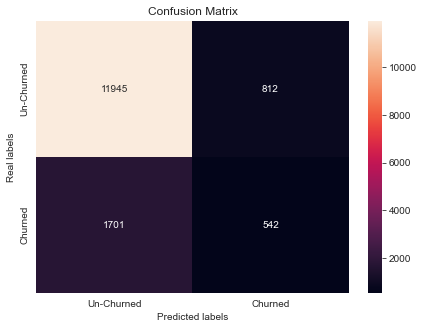

In [140]:
## Prediction
y_pred = base_model.predict(X_test)

produce_confusion('Churned', 'Un-Churned',y_test,y_pred)

In [141]:
from sklearn.metrics import classification_report
# Print the classification report
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.88      0.94      0.90     12757
           1       0.40      0.24      0.30      2243

    accuracy                           0.83     15000
   macro avg       0.64      0.59      0.60     15000
weighted avg       0.80      0.83      0.81     15000



In [142]:


# rf_base = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'])
# # Train the model with a progress bar
# for _ in tqdm(range(rf_base.n_estimators)):
#     rf_base.fit(X_train_resampled,y_train_resampled)

In [143]:
# y_train_resampled=np.array(y_train_resampled)
# y_test=np.array(y_test)

In [144]:
# apr(y_pred,y_test)

# Undersample

Random Undersampler

In [145]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the training data using random undersampling
rus = RandomUnderSampler(random_state=42)
X_train_U, y_train_U = rus.fit_resample(X_train, y_train)
print('X_train shape:',X_train_U.shape)
print('y_train shape:',y_train_U.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (10470, 13)
y_train shape: (10470,)
X_test shape: (15000, 13)
y_test shape: (15000,)


### Custom Undersampler

In [174]:
def undersample(df):

    positive_df = df[df['booking_complete']=='1']
    negative_df = df[df['booking_complete']!='1']
    negative_df=negative_df.sample(n=int((positive_df.shape[0])*1.25))

    df_new=pd.concat([positive_df,negative_df],axis=0)

    features=df_new.columns.to_list()
    features.remove('booking_complete')

    X=df_new[features]
    y=df_new['booking_complete']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

    return X_train, X_test, y_train, y_test

    
X_train_u, X_test_u, y_train_u, y_test_u = undersample(booking_df_new)
print('X_train shape:',X_train_u.shape)
print('y_train shape:',y_train_u.shape)
print('X_test shape:',X_test_u.shape)
print('y_test shape:',y_test_u.shape)    

X_train shape: (12618, 13)
y_train shape: (12618,)
X_test shape: (4207, 13)
y_test shape: (4207,)


In [175]:
y_train_u.value_counts()

0    7010
1    5608
Name: booking_complete, dtype: int64

In [176]:
best_params = get_best_params(X_train_u,y_train_u)
best_params

0.7067673442365106


{'max_depth': 11, 'n_estimators': 250}

In [177]:
model1 = rfU_model(X_train_u,y_train_u,best_params,modelname='model1.pkl')

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration'],
      dtype='object')


100%|██████████| 250/250 [09:54<00:00,  2.38s/it]


In [178]:
from sklearn.metrics import classification_report

## Prediction
y_pred = model1.predict(X_test_u)
# Print the classification report
print(classification_report(y_test_u, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      2337
           1       0.67      0.68      0.67      1870

    accuracy                           0.71      4207
   macro avg       0.70      0.70      0.70      4207
weighted avg       0.71      0.71      0.71      4207



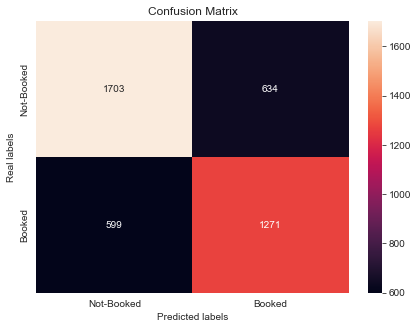

In [179]:
## Prediction
y_pred = model1.predict(X_test_u)

produce_confusion('Booked', 'Not-Booked',y_test_u,y_pred)

In [180]:
# Get the feature importances
importances = model1.feature_importances_

feature_names = X_test_u.columns.to_list()

# Print the importances
print(f"Feature importances: {importances}")
print(f"Features: {feature_names}")

Feature importances: [0.03036602 0.02061854 0.00391074 0.10258314 0.11998826 0.07160588
 0.04548748 0.13670933 0.30217928 0.03487335 0.01959426 0.0175231
 0.09456061]
Features: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']


Text(0.5, 0, 'Important features')

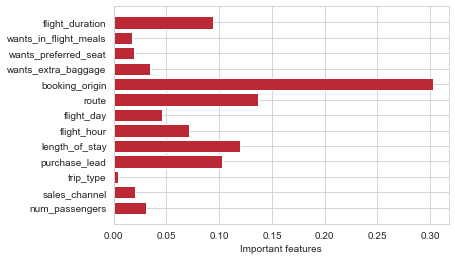

In [181]:


# Plot the importances
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), feature_names)
plt.xlabel("Important features")

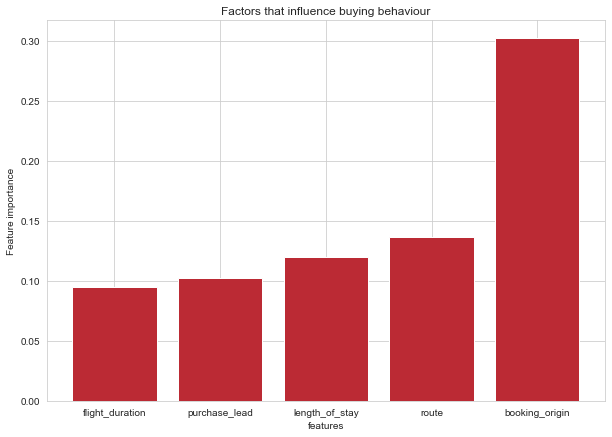

In [206]:
# Zip the lists and sort by the values in list1
sorted_filtered_lists = [tup for tup in sorted(zip(importances, feature_names), key=lambda x: x[0]) if tup[0] >= 0.08]
# Unzip the sorted lists
importances, feature_names = zip(*sorted_filtered_lists)

importances, feature_names = list(importances), list(feature_names)

# Plot the importances

# Set figure size

plt.figure(figsize=(10, 7))
plt.title('Factors that influence buying behaviour')
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(feature_names)), feature_names)
plt.xlabel("features")
plt.ylabel("Feature importance")

plt.show()


In [183]:
feature_names

['flight_duration',
 'purchase_lead',
 'length_of_stay',
 'route',
 'booking_origin']

In [184]:
[i in list(X_train_u.columns) for i in feature_names ]

[True, True, True, True, True]

In [185]:
X_train_u[feature_names]

,flight_duration,purchase_lead,length_of_stay,route,booking_origin
16765,7.00,4,180,548,43
40298,7.00,310,5,548,43
22085,8.83,157,17,693,4
45049,5.07,229,6,298,17
41167,6.42,30,5,701,51
...,...,...,...,...,...
7538,8.83,61,20,218,4
38940,7.57,24,5,404,80
49975,4.67,265,6,717,91
37041,8.83,35,5,289,36


In [186]:
model2 = rfU_model(X_train_u[feature_names],y_train_u,best_params,modelname='model2.pkl')


Index(['flight_duration', 'purchase_lead', 'length_of_stay', 'route',
       'booking_origin'],
      dtype='object')


100%|██████████| 250/250 [09:14<00:00,  2.22s/it]


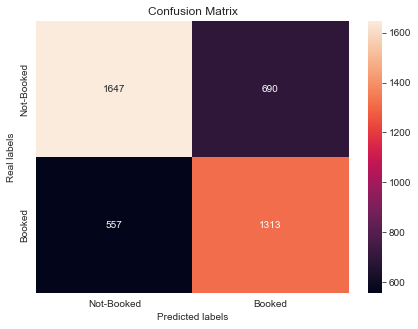

In [187]:
## Prediction
y_pred = model2.predict(X_test_u[feature_names])

produce_confusion('Booked', 'Not-Booked',y_test_u,y_pred)

Predicted counts

In [188]:
# Get the value counts
unique, counts = np.unique(y_pred, return_counts=True)

# Print the results
print(f"Values: {unique}")
print(f"Counts: {counts}")

Values: ['0' '1']
Counts: [2204 2003]


Real labels counts

In [189]:
# Get the value counts
unique, counts = np.unique(y_test_u, return_counts=True)

# Print the results
print(f"Values: {unique}")
print(f"Counts: {counts}")

Values: ['0' '1']
Counts: [2337 1870]


In [190]:
from sklearn.metrics import classification_report
# Print the classification report
print(classification_report(y_test_u, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.75      0.70      0.73      2337
           1       0.66      0.70      0.68      1870

    accuracy                           0.70      4207
   macro avg       0.70      0.70      0.70      4207
weighted avg       0.71      0.70      0.70      4207



               precision    recall  f1-score   support

           0       0.75      0.77      0.76      2243
           1       0.64      0.61      0.62      1496

    accuracy                           0.71      3739
   macro avg       0.69      0.69      0.69      3739
weighted avg       0.70      0.71      0.71      3739

Precision = True Positives / (True Positives + False Positives)

A classifier with high precision has a low false positive rate, which means that it rarely predicts a positive class when the actual class is negative.


Recall = True Positives / (True Positives + False Negatives)
A classifier with high recall has a low false negative rate, which means that it rarely misses actual positive samples.

In [191]:
import joblib

# # Save the model to a file
# joblib.dump(model2, 'rf_model.pkl')



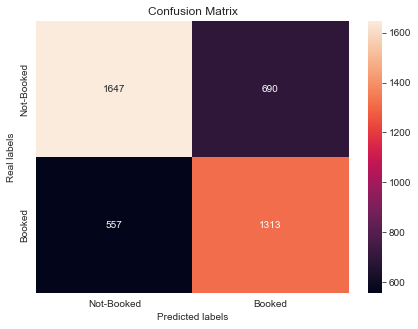

In [192]:
# Load the model from a file
loaded_model = joblib.load('model2.pkl')
## Prediction
y_pred = loaded_model.predict(X_test_u[feature_names])
y_pred_proba = loaded_model.predict_log_proba(X_test_u[feature_names])

produce_confusion('Booked', 'Not-Booked',y_test_u,y_pred)

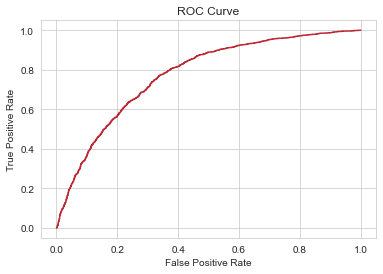

In [193]:
# Calculate the false positive rates, true positive rates, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_u, y_pred_proba[:,1],pos_label='1')

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

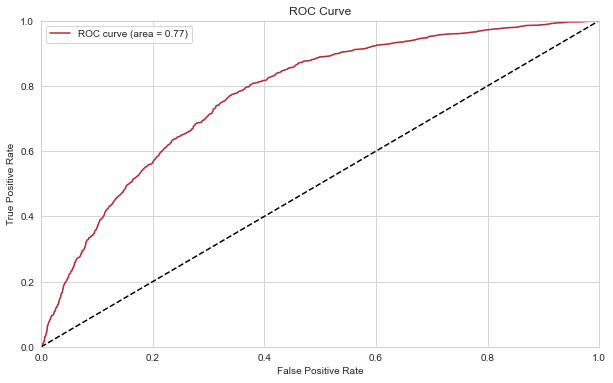

In [194]:
from sklearn.metrics import auc

# Calculate the AUC
roc_auc = auc(fpr, tpr)


# Set figure size
plt.figure(figsize=(10, 6))

# Plot ROC curve
sns.lineplot(x=fpr,y=tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [207]:
# Create a tqdm progress bar
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

with tqdm(total=5) as pbar:
    # Calculate cross-validated accuracy with a for loop
    scores = []# Use StratifiedKFold with 5 folds

    for i in range(5):
        score = cross_val_score(loaded_model, X[feature_names], y, cv=skf, verbose=0,
                                scoring='accuracy')
        scores.append(score)
        # Update the progress bar manually
        pbar.update()

# Print mean and standard deviation of accuracy scores
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

100%|██████████| 5/5 [02:35<00:00, 31.13s/it]

Accuracy: 0.85 (+/- 0.00)


In [196]:
import sklearn
print(sklearn.__version__)


1.0.2


In [197]:
def ccp_alpha_selection(ccp_alphas, impurities, X, y):
    # Initialize a list to store the misclassification errors and ccp_alphas
    errors = []
    
    # Iterate over the ccp_alphas
    for ccp_alpha, impurity in zip(ccp_alphas, impurities):
        # Create a decision tree model using the current value of ccp_alpha
        tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
        
        # Fit the model to the data
        tree.fit(X, y)
        
        # Make predictions on the data
        y_pred = tree.predict(X)
        
        # Calculate the misclassification error
        error = 1 - accuracy_score(y, y_pred)
        
        # Append the error and ccp_alpha to the list
        errors.append((error, ccp_alpha))
    
    # Sort the list by misclassification error
    errors.sort()
    
    # Return the value of ccp_alpha that corresponds to the lowest misclassification error
    return errors[0][1]


In [198]:
# from sklearn.tree import DecisionTreeClassifier

# # Create a list of the decision trees in the random forest
# trees = [DecisionTreeClassifier(ccp_alpha=0).fit(X_train_u, y_train_u) for tree in loaded_model.estimators_]

# # Compute the cost-complexity pruning path for each tree
# paths = [tree.cost_complexity_pruning_path(X_train_u, y_train_u) for tree in trees]

# # Select the optimal value of ccp_alpha for each tree
# ccp_alphas = [path.ccp_alphas[:-1] for path in paths]
# optimal_ccp_alphas = [ccp_alpha_selection(ccp_alpha, path.impurities, X_train_u, y_train_u) for ccp_alpha, path in zip(ccp_alphas, paths)]

# print("Optimal ccp_alphas:", optimal_ccp_alphas)

# # Prune the trees using the optimal values of ccp_alpha
# pruned_trees = []
# for alpha in tqdm(optimal_ccp_alphas):
#     pruned_trees.append(DecisionTreeClassifier(ccp_alpha=alpha).fit(X_train_u, y_train_u))

# # Create a new random forest model with the pruned trees
# pruned_rfmodel = RandomForestClassifier(random_state=42, base_estimator=None).fit(X_train_u, y_train_u)
